Reference - https://github.com/LoyoYang/DeCoTa.git 

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [ ]:
import torch
from __future__ import print_function
import argparse
import os
import sys
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
sys.path.insert(0,'/content/drive/MyDrive/DeCoTa')
sys.path.insert(0,'/content/drive/MyDrive/DeCoTa/model')

In [ ]:
import meta_modules
from model.resnet_model import MetaResnet34
from utils.lr_schedule import inv_lr_scheduler
from utils.return_dataset import return_dataset
#from utils.return_new import return_new

# Main training functions

In [ ]:
class Arguments():

  def __init__(self):
        self.steps = 5000                     #max number of iterations
        self.method = 'mico'                   #mico or mist
        self.lr = 0.01                         #learning rate
        self.multi = 0.1                       #lr multiplication factor
        self.save_check = False                #save checkpoint or not
        self.checkpath ='/content/drive/MyDrive/DeCoTa/checkpoints'         #dir to save checkpoint
        self.seed = 1                          #random seed (default:1)
        self.log_interval = 100                #how many batches to wait before logging training status
        self.save_interval = 500               #how many batches to wait before saving a model
        self.net = 'resnet34'                  #which network to use
        self.source = 'sketch'                   #source domain
        self.target = 'clipart'                #target domain
        self.st = 0
        self.dataset = 'multi'
        self.num = 3                           #3-shot/1-shot 
        self.th = 0.5                          #threshold
        self.root = '/content/drive/MyDrive/DeCoTa'
        self.net_resume = ''
        self.start = 0
        self.runs = 999
        self.eval = False

In [ ]:
def train():
    net.train()
    twin.train()

    optimizer_g = optim.SGD(params, momentum=0.9,
                            weight_decay=0.0005, nesterov=True)
    optimizer_f = optim.SGD(params_F1, lr=1.0, momentum=0.9,
                            weight_decay=0.0005, nesterov=True)
    optimizer_g_2 = optim.SGD(params_2, momentum=0.9,
                            weight_decay=0.0005, nesterov=True)
    optimizer_f_2 = optim.SGD(params_F2, lr=1.0, momentum=0.9,
                            weight_decay=0.0005, nesterov=True)

    def zero_grad_all():  #accumulation of gradient over mini-baches
        optimizer_g.zero_grad()
        optimizer_f.zero_grad()
        optimizer_g_2.zero_grad()
        optimizer_f_2.zero_grad()

    param_lr_g = []
    param_lr_g_2 = []
    param_lr_f = []
    param_lr_f_2 = []

    for param_group in optimizer_g.param_groups:
        param_lr_g.append(param_group["lr"])
    for param_group in optimizer_g_2.param_groups:
        param_lr_g_2.append(param_group["lr"])
    for param_group in optimizer_f.param_groups:
        param_lr_f.append(param_group["lr"])
    for param_group in optimizer_f_2.param_groups:
        param_lr_f_2.append(param_group["lr"])

    criterion = nn.CrossEntropyLoss().cuda()
    criterion_no_reduce = nn.CrossEntropyLoss(reduction='none').cuda()
    all_step = args.steps
    data_iter_s = iter(source_loader)
    data_iter_t = iter(target_loader)
    data_iter_t_unl = iter(target_loader_unl)
    len_train_source = len(source_loader)
    len_train_target = len(target_loader)
    len_train_target_semi = len(target_loader_unl)
    best_acc = 0
    counter = 0

    for step in range(args.start, all_step):

        optimizer_g = inv_lr_scheduler(param_lr_g, optimizer_g, step,
                                       init_lr=args.lr)
        optimizer_g_2 = inv_lr_scheduler(param_lr_g_2, optimizer_g_2, step,
                                       init_lr=args.lr)
        optimizer_f = inv_lr_scheduler(param_lr_f, optimizer_f, step,
                                       init_lr=args.lr)
        optimizer_f_2 = inv_lr_scheduler(param_lr_f_2, optimizer_f_2, step,
                                       init_lr=args.lr)
        lr = optimizer_f.param_groups[0]['lr']

        if step % len_train_target == 0:
            data_iter_t = iter(target_loader)
        if step % len_train_target_semi == 0:
            data_iter_t_unl = iter(target_loader_unl)
        if step % len_train_source == 0:
            data_iter_s = iter(source_loader)
        data_t = next(data_iter_t)
        data_t_unl = next(data_iter_t_unl)
        data_s = next(data_iter_s)

        with torch.no_grad():

            im_data_s.resize_(data_s[0].size()).copy_(data_s[0])
            gt_labels_s.resize_(data_s[1].size()).copy_(data_s[1])
            im_data_t.resize_(data_t[0].size()).copy_(data_t[0])
            gt_labels_t.resize_(data_t[1].size()).copy_(data_t[1])
            im_data_tu.resize_(data_t_unl[0].size()).copy_(data_t_unl[0])

        """stream 1"""
        zero_grad_all()
        data = im_data_t
        target = gt_labels_t
        out_1 = net(data)
        loss_1 = criterion_no_reduce(out_1, target).mean()
        zero_grad_all()

        """stream 2"""
        data = im_data_s
        target = gt_labels_s
        out_2 = twin(data)
        loss_2 = criterion_no_reduce(out_2, target).mean()
        zero_grad_all()

        """pseudo-label"""
        u_1_prob = torch.softmax(net(im_data_tu), dim=1)
        u_1_pred = u_1_prob.max(1)
        u_2_prob = torch.softmax(twin(im_data_tu), dim=1)
        u_2_pred = u_2_prob.max(1)

        u_1_mask = u_1_pred[0] >= args.th
        u_2_mask = u_2_pred[0] >= args.th

        im_u_1 = im_data_tu[u_2_mask]
        psl_u_1 = u_2_pred[1][u_2_mask]
        im_u_2 = im_data_tu[u_1_mask]
        psl_u_2 = u_1_pred[1][u_1_mask]

        """mix_up"""
        alpha = 1
        lam = np.random.beta(alpha, alpha)
        # stream 1
        if im_u_1.size(0) > 0:

            size_1 = im_u_1.size(0)
            # print('stream 1: {}'.format(size_1))

            t_idx = torch.randperm(im_data_t.size(0))[0:size_1]
            mixed_x = lam * im_data_t[t_idx] + (1-lam) * im_u_1
            y_a, y_b = gt_labels_t[t_idx], psl_u_1

            out_mix = net(mixed_x)
            loss_mix_1 = lam * criterion(out_mix, y_a) + (1-lam) * criterion(out_mix, y_b)

            loss_1 += loss_mix_1
            zero_grad_all()
            loss_1.backward(retain_graph=True)
            optimizer_f.step()
            optimizer_g.step()
        else:
            zero_grad_all()
            loss_1.backward(retain_graph=True)
            optimizer_f.step()
            optimizer_g.step()

        zero_grad_all()
        # stream 2
        if im_u_2.size(0) > 0:
            size_2 = im_u_2.size(0)
            # print('stream 2: {}'.format(size_2))
            s_idx = torch.randperm(im_data_s.size(0))[0:size_2]
            mixed_x = (1-lam) * im_data_s[s_idx] + lam * im_u_2
            y_a, y_b = gt_labels_s[s_idx], psl_u_2
            out_mix = twin(mixed_x)
            loss_mix_2 = (1-lam) * criterion(out_mix, y_a) + lam * criterion(out_mix, y_b)
            loss_2 += loss_mix_2
            zero_grad_all()
            loss_2.backward()
            optimizer_f_2.step()
            optimizer_g_2.step()
        else:
            zero_grad_all()
            loss_2.backward()
            optimizer_f_2.step()
            optimizer_g_2.step()
        zero_grad_all()

        log_train = 'S {} T {} Train Ep: {} lr{} \t ' \
                    'Method {}\n'.\
            format(args.source, args.target,
                   step, lr,
                   args.method)
        net.zero_grad()
        twin.zero_grad()
        zero_grad_all()
        if step % args.log_interval == 0:
            print(log_train)

        if step % args.save_interval == 0:

            acc_test_net, acc_test_twin, acc_test = test_ensemble(target_loader_test)
            acc_val_net, acc_val_twin, acc_val = test_ensemble(target_loader_val)

            net.train()
            twin.train()
            if acc_val >= best_acc:
                best_acc = acc_val
                best_acc_test = acc_test
                counter = 0
            else:
                counter += 1

            print('test acc %f best acc test %f best acc val %f' % (acc_test,
                                                                    best_acc_test,
                                                                    best_acc))
            print('record %s' % record_file)
            with open(record_file, 'a') as f:
                f.write('step %d wf %f wg %f mico %f best mico %f best val %f \n' % (step,
                                                                                     acc_test_net,
                                                                                     acc_test_twin,
                                                                                     acc_test,
                                                                                     best_acc_test,
                                                                                     best_acc))
            net.train()
            twin.train()
            if args.save_check:
                print('saving model')
                torch.save(net.state_dict(),
                           os.path.join(args.checkpath,
                                        "Net_iter_model_{}_{}_"
                                        "to_{}_step_{}.pth.tar".
                                        format(args.method, args.source,
                                               args.target, step)))
                torch.save(twin.state_dict(),
                           os.path.join(args.checkpath,
                                        "Twin_iter_model_{}_{}_"
                                        "to_{}_step_{}.pth.tar".
                                        format(args.method, args.source,
                                               args.target, step)))


def test_ensemble(loader):
    net.eval()
    twin.eval()
    correct = 0
    correct_test_1 = 0
    correct_test_2 = 0
    total = 0

    with torch.no_grad():
        print(len(list(enumerate(loader))))
        for batch_idx, data_t in enumerate(loader):
            im_data_t.resize_(data_t[0].size()).copy_(data_t[0])
            gt_labels_t.resize_(data_t[1].size()).copy_(data_t[1])
            output1 = net(im_data_t)
            output2 = twin(im_data_t)
            print(batch_idx)

            """test 1 and 2"""
            pred_test_1 = output1.max(1)[1]
            pred_test_2 = output2.max(1)[1]

            correct_test_1 += pred_test_1.eq(gt_labels_t).sum().item()
            correct_test_2 += pred_test_2.eq(gt_labels_t).sum().item()

            """ensemble results"""
            output = torch.softmax(output1, dim=1) + torch.softmax(output2, dim=1)
            pred = output.max(1)[1]

            total += gt_labels_t.size(0)
            correct += pred.eq(gt_labels_t).sum().item()

    acc_test_1 = 100. * (float(correct_test_1)/total)
    acc_test_2 = 100. * (float(correct_test_2)/total)
    acc = 100. * (float(correct)/total)

    return acc_test_1, acc_test_2, acc


# Clipart to Sketch - Data Loading

In [ ]:
!wget -P /content/drive/MyDrive/DeCoTa/clipart http://csr.bu.edu/ftp/visda/2019/multi-source/groundtruth/clipart.zip  
!wget -P /content/drive/MyDrive/DeCoTa/sketch http://csr.bu.edu/ftp/visda/2019/multi-source/sketch.zip 

--2022-04-13 06:28:19--  http://csr.bu.edu/ftp/visda/2019/multi-source/groundtruth/clipart.zip
Resolving csr.bu.edu (csr.bu.edu)... 128.197.11.70
Connecting to csr.bu.edu (csr.bu.edu)|128.197.11.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1270909081 (1.2G) [application/zip]
Saving to: ‘/content/drive/MyDrive/DeCoTa/clipart/clipart.zip’

clipart.zip         100%[===================>]   1.18G  8.81MB/s    in 5m 8s   

2022-04-13 06:33:28 (3.93 MB/s) - ‘/content/drive/MyDrive/DeCoTa/clipart/clipart.zip’ saved [1270909081/1270909081]

--2022-04-13 06:33:29--  http://csr.bu.edu/ftp/visda/2019/multi-source/sketch.zip
Resolving csr.bu.edu (csr.bu.edu)... 128.197.11.70
Connecting to csr.bu.edu (csr.bu.edu)|128.197.11.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2633992926 (2.5G) [application/zip]
Saving to: ‘/content/drive/MyDrive/DeCoTa/sketch/sketch.zip’

sketch.zip          100%[===================>]   2.45G  3.47MB/s    in 11m 

In [ ]:
!unzip /content/drive/MyDrive/DeCoTa/sketch/sketch.zip -d /content/drive/MyDrive/DeCoTa/sketch

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/DeCoTa/sketch/sketch/tree/sketch_323_000134.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/sketch/sketch/tree/sketch_323_000135.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/sketch/sketch/tree/sketch_323_000136.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/sketch/sketch/tree/sketch_323_000137.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/sketch/sketch/tree/sketch_323_000138.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/sketch/sketch/tree/sketch_323_000139.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/sketch/sketch/tree/sketch_323_000140.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/sketch/sketch/tree/sketch_323_000141.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/sketch/sketch/tree/sketch_323_000142.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/sketch/sketch/tree/sketch_323_000143.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/sketch/sketch/tree/sketch_323_000144.jpg  
  i

In [ ]:
!unzip /content/drive/MyDrive/DeCoTa/clipart/clipart.zip -d /content/drive/MyDrive/DeCoTa/clipart

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/DeCoTa/clipart/clipart/tractor/clipart_320_000104.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/clipart/clipart/tractor/clipart_320_000105.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/clipart/clipart/tractor/clipart_320_000106.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/clipart/clipart/tractor/clipart_320_000107.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/clipart/clipart/tractor/clipart_320_000108.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/clipart/clipart/tractor/clipart_320_000109.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/clipart/clipart/tractor/clipart_320_000110.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/clipart/clipart/tractor/clipart_320_000111.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/clipart/clipart/tractor/clipart_320_000112.jpg  
  inflating: /content/drive/MyDrive/DeCoTa/clipart/clipart/tractor/clipart_320_000113.jpg  
  inflating: /content/drive/M

# Training (5000 steps)

In [ ]:
args = Arguments()
multi = [['real', 'clipart'], ['real', 'painting'],
         ['painting', 'clipart'], ['clipart','sketch'],
         ['sketch', 'painting'], ['real', 'sketch'],
         ['painting', 'real']]
        
if args.st != 0 and args.dataset == 'multi':    #default 0
    args.source, args.target = multi[args.st-1]

print('Dataset- %s , Source- %s , Target- %s , Labeled num perclass- %s , Network- %s' %
      (args.dataset, args.source, args.target, args.num, args.net))

Dataset- multi , Source- sketch , Target- clipart , Labeled num perclass- 3 , Network- resnet34


In [ ]:
source_loader, target_loader, target_loader_unl, target_loader_val, \
    target_loader_test, class_list = return_dataset(args=args, return_idx=False)

126 classes in this dataset


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
""" net: w_f; twin: w_g """
use_gpu = torch.cuda.is_available()
torch.cuda.manual_seed(args.seed)

if args.net == 'resnet34':   #object of MetaResnet34 inherits from nn.Module
    net = MetaResnet34(num_class=len(class_list))   #init weights
    twin = MetaResnet34(num_class=len(class_list))

params = []
for value in net.G.params():  #resnet model params
    if value.requires_grad:
        params += [{'params': [value], 'lr': args.multi,
                    'weight_decay': 0.0005}]
params_F1 = []
for value in net.F1.params():
    if value.requires_grad:
        params_F1 += [{'params': [value], 'lr': args.multi,
                       'weight_decay': 0.0005}]

params_2 = []
for value in twin.G.params():
    if value.requires_grad:
        params_2 += [{'params': [value], 'lr': args.multi,
                    'weight_decay': 0.0005}]

params_F2 = []
for value in twin.F1.params():
    if value.requires_grad:
        params_F2 += [{'params': [value], 'lr': args.multi,
                       'weight_decay': 0.0005}]

Downloading: "https://s3.amazonaws.com/pytorch/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
""" record & resume path """
args.checkpath = os.path.join(args.checkpath, 'runs_{}'.format(args.runs))
if not os.path.exists(args.checkpath):
    os.makedirs(args.checkpath)

record_dir = '/content/drive/MyDrive/DeCoTa/record/%s/mico' % args.dataset
if not os.path.exists(record_dir):
    os.makedirs(record_dir)
record_file = os.path.join(record_dir,
                           'exp_net_%s_%s_to_%s_num_%s_%d' %
                           (args.net, args.source,
                            args.target, args.num, args.runs))


In [ ]:
lr = args.lr
net.cuda()
twin.cuda()

im_data_s = torch.FloatTensor(1)
im_data_t = torch.FloatTensor(1)
im_data_tu = torch.FloatTensor(1)
im_data_tu_2 = torch.FloatTensor(1)
gt_labels_s = torch.LongTensor(1)
gt_labels_t = torch.LongTensor(1)

im_data_s = im_data_s.cuda()
im_data_t = im_data_t.cuda()
im_data_tu = im_data_tu.cuda()
im_data_tu_2 = im_data_tu_2.cuda()
gt_labels_s = gt_labels_s.cuda()
gt_labels_t = gt_labels_t.cuda()

im_data_s = Variable(im_data_s)
im_data_t = Variable(im_data_t)
im_data_tu = Variable(im_data_tu)
im_data_tu_2 = Variable(im_data_tu_2)
sgt_labels_s = Variable(gt_labels_s)
gt_labels_t = Variable(gt_labels_t)

In [ ]:
if args.eval:
    print('eval mode...')
    acc_test_net, acc_test_twin, acc_test = test_ensemble(target_loader_test)
    print('net acc: {}, twin acc: {}, mico acc: {}'.format(acc_test_net, acc_test_twin, acc_test))
else:
    train()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


S sketch T clipart Train Ep: 0 lr0.001 	 Method mico

test acc 0.867667 best acc test 0.867667 best acc val 0.555556
record /content/drive/MyDrive/DeCoTa/record/multi/mico/exp_net_resnet34_sketch_to_clipart_num_3_999
S sketch T clipart Train Ep: 100 lr0.0009925650290240804 	 Method mico

S sketch T clipart Train Ep: 200 lr0.0009852577760521605 	 Method mico

S sketch T clipart Train Ep: 300 lr0.0009780748269686728 	 Method mico

S sketch T clipart Train Ep: 400 lr0.0009710128909124701 	 Method mico

S sketch T clipart Train Ep: 500 lr0.0009640687946943232 	 Method mico

test acc 44.327422 best acc test 44.327422 best acc val 45.277778
record /content/drive/MyDrive/DeCoTa/record/multi/mico/exp_net_resnet34_sketch_to_clipart_num_3_999
S sketch T clipart Train Ep: 600 lr0.0009572394775176031 	 Method mico

S sketch T clipart Train Ep: 700 lr0.0009505219859830012 	 Method mico

S sketch T clipart Train Ep: 800 lr0.0009439134693595126 	 Method mico

S sketch T clipart Train Ep: 900 lr0.0009

In [ ]:
args.eval = True
print('eval mode...')
acc_test_net, acc_test_twin, acc_test = test_ensemble(target_loader_test)
print('net acc: {}, twin acc: {}, mico acc: {}'.format(acc_test_net, acc_test_twin, acc_test))

eval mode...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


net acc: 67.34515688949523, twin acc: 68.61118690313779, mico acc: 70.33015006821283


# VISDA17 Dataset Loading

In [ ]:
!wget -P /content/drive/MyDrive/DeCoTa/data/visda17 http://csr.bu.edu/ftp/visda17/clf/train.tar
!wget -P /content/drive/MyDrive/DeCoTa/data/visda17 http://csr.bu.edu/ftp/visda17/clf/validation.tar
!wget -P /content/drive/MyDrive/DeCoTa/data/visda17 http://csr.bu.edu/ftp/visda17/clf/test.tar
!wget -P /content/drive/MyDrive/DeCoTa/data/visda17 https://raw.githubusercontent.com/VisionLearningGroup/taskcv-2017-public/master/classification/data/image_list.txt

--2022-04-16 10:04:31--  http://csr.bu.edu/ftp/visda17/clf/train.tar
Resolving csr.bu.edu (csr.bu.edu)... 128.197.11.70
Connecting to csr.bu.edu (csr.bu.edu)|128.197.11.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7698031104 (7.2G) [application/x-tar]
Saving to: ‘/content/drive/MyDrive/DeCoTa/data/visda17/train.tar’

train.tar           100%[===================>]   7.17G  17.1MB/s    in 5m 50s  

2022-04-16 10:10:21 (21.0 MB/s) - ‘/content/drive/MyDrive/DeCoTa/data/visda17/train.tar’ saved [7698031104/7698031104]

--2022-04-16 10:10:21--  http://csr.bu.edu/ftp/visda17/clf/validation.tar
Resolving csr.bu.edu (csr.bu.edu)... 128.197.11.70
Connecting to csr.bu.edu (csr.bu.edu)|128.197.11.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1023758336 (976M) [application/x-tar]
Saving to: ‘/content/drive/MyDrive/DeCoTa/data/visda17/validation.tar’

validation.tar      100%[===================>] 976.33M  11.1MB/s    in 57s     

2022-04-

In [ ]:
!tar -xvf /content/drive/MyDrive/DeCoTa/data/visda17/train.tar -C /content/drive/MyDrive/DeCoTa/data/visda17
!tar -xvf /content/drive/MyDrive/DeCoTa/data/visda17/test.tar -C /content/drive/MyDrive/DeCoTa/data/visda17
!tar -xvf /content/drive/MyDrive/DeCoTa/data/visda17/validation.tar -C /content/drive/MyDrive/DeCoTa/data/visda17

Streaming output truncated to the last 5000 lines.
validation/car/car_141250.jpg
validation/motorcycle/motorcycle_151285.jpg
validation/car/car_350060.jpg
validation/bicycle/bicycle_241585.jpg
validation/horse/horse_56444.jpg
validation/motorcycle/motorcycle_1362775.jpg
validation/bus/bus_168595.jpg
validation/car/car_133023.jpg
validation/motorcycle/motorcycle_1792603.jpg
validation/plant/plant_1954060.jpg
validation/bus/bus_163253.jpg
validation/horse/horse_58912.jpg
validation/car/car_1191884.jpg
validation/horse/horse_54157.jpg
validation/person/person_1208955.jpg
validation/bicycle/bicycle_128748.jpg
validation/truck/truck_2051524.jpg
validation/bus/bus_163639.jpg
validation/bus/bus_167444.jpg
validation/person/person_1205336.jpg
validation/person/person_1209141.jpg
validation/bicycle/bicycle_127211.jpg
validation/car/car_133409.jpg
validation/aeroplane/aeroplane_158674.jpg
validation/car/car_1779282.jpg
validation/truck/truck_395960.jpg
validation/horse/horse_58348.jpg
validation

# Training on VISDA

In [ ]:
args = Arguments()

In [ ]:
args.steps = 1000                     #max number of iterations
args.method = 'mico'                   #mico or mist
args.lr = 0.01                         #learning rate
args.multi = 0.1                       #lr multiplication factor
args.save_check = False                #save checkpoint or not
args.checkpath ='/content/drive/MyDrive/DeCoTa/checkpoints'         #dir to save checkpoint
args.seed = 1                          #random seed (default:1)
args.log_interval = 50                #how many batches to wait before logging training status
args.save_interval = 100               #how many batches to wait before saving a model
args.net = 'resnet34'                  #which network to use
args.source = 'synthetic'              #source domain
args.target = 'real'                   #target domain
args.st = 0
args.dataset = 'VISDA17'
args.num = 3                           #3-shot/1-shot 
args.th = 0.5                          #threshold
args.root = '/content/drive/MyDrive/DeCoTa'
args.net_resume = ''
args.start = 0
args.runs = 999
args.eval = False

In [ ]:
print('Dataset- %s , Source- %s , Target- %s , Labeled num perclass- %s , Network- %s' %
      (args.dataset, args.source, args.target, args.num, args.net))

Dataset- VISDA17 , Source- synthetic , Target- real , Labeled num perclass- 3 , Network- resnet34


In [ ]:
source_loader, target_loader, target_loader_unl, target_loader_val, \
    target_loader_test, class_list = return_dataset(args=args, return_idx=False)

12 classes in this dataset


In [ ]:
""" net: w_f; twin: w_g """
use_gpu = torch.cuda.is_available()
torch.cuda.manual_seed(args.seed)

if args.net == 'resnet34':   #object of MetaResnet34 inherits from nn.Module
    net = MetaResnet34(num_class=len(class_list))   #init weights
    twin = MetaResnet34(num_class=len(class_list))

params = []
for value in net.G.params():  #resnet model params
    if value.requires_grad:
        params += [{'params': [value], 'lr': args.multi,
                    'weight_decay': 0.0005}]
params_F1 = []
for value in net.F1.params():
    if value.requires_grad:
        params_F1 += [{'params': [value], 'lr': args.multi,
                       'weight_decay': 0.0005}]

params_2 = []
for value in twin.G.params():
    if value.requires_grad:
        params_2 += [{'params': [value], 'lr': args.multi,
                    'weight_decay': 0.0005}]

params_F2 = []
for value in twin.F1.params():
    if value.requires_grad:
        params_F2 += [{'params': [value], 'lr': args.multi,
                       'weight_decay': 0.0005}]

Downloading: "https://s3.amazonaws.com/pytorch/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
""" record & resume path """
args.checkpath = os.path.join(args.checkpath, 'runs_{}'.format(args.runs))
if not os.path.exists(args.checkpath):
    os.makedirs(args.checkpath)

record_dir = '/content/drive/MyDrive/DeCoTa/record/%s/mico' % args.dataset
if not os.path.exists(record_dir):
    os.makedirs(record_dir)
record_file = os.path.join(record_dir,
                           'exp_net_%s_%s_to_%s_num_%s_%d' %
                           (args.net, args.source,
                            args.target, args.num, args.runs))


In [ ]:
lr = args.lr
net.cuda()
twin.cuda()

im_data_s = torch.FloatTensor(1)
im_data_t = torch.FloatTensor(1)
im_data_tu = torch.FloatTensor(1)
im_data_tu_2 = torch.FloatTensor(1)
gt_labels_s = torch.LongTensor(1)
gt_labels_t = torch.LongTensor(1)

im_data_s = im_data_s.cuda()
im_data_t = im_data_t.cuda()
im_data_tu = im_data_tu.cuda()
im_data_tu_2 = im_data_tu_2.cuda()
gt_labels_s = gt_labels_s.cuda()
gt_labels_t = gt_labels_t.cuda()

im_data_s = Variable(im_data_s)
im_data_t = Variable(im_data_t)
im_data_tu = Variable(im_data_tu)
im_data_tu_2 = Variable(im_data_tu_2)
sgt_labels_s = Variable(gt_labels_s)
gt_labels_t = Variable(gt_labels_t)

In [ ]:
if args.eval:
    print('eval mode...')
    acc_test_net, acc_test_twin, acc_test = test_ensemble(target_loader_test)
    print('net acc: {}, twin acc: {}, mico acc: {}'.format(acc_test_net, acc_test_twin, acc_test))
else:
    train()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


S synthetic T real Train Ep: 0 lr9.846786101083232e-06 	 Method mico

2
0
1
1
0
test acc 77.777778 best acc test 77.777778 best acc val 75.000000
record /content/drive/MyDrive/DeCoTa/record/VISDA17/mico/exp_net_resnet34_synthetic_to_real_num_3_999
S synthetic T real Train Ep: 50 lr9.810021465060851e-06 	 Method mico

S synthetic T real Train Ep: 100 lr9.773575532215587e-06 	 Method mico

2
0
1
1
0
test acc 77.777778 best acc test 77.777778 best acc val 83.333333
record /content/drive/MyDrive/DeCoTa/record/VISDA17/mico/exp_net_resnet34_synthetic_to_real_num_3_999
S synthetic T real Train Ep: 150 lr9.737443982471478e-06 	 Method mico

S synthetic T real Train Ep: 200 lr9.70162257521459e-06 	 Method mico

2
0
1
1
0
test acc 77.777778 best acc test 77.777778 best acc val 83.333333
record /content/drive/MyDrive/DeCoTa/record/VISDA17/mico/exp_net_resnet34_synthetic_to_real_num_3_999
S synthetic T real Train Ep: 250 lr9.666107147450721e-06 	 Method mico

S synthetic T real Train Ep: 300 lr9.6

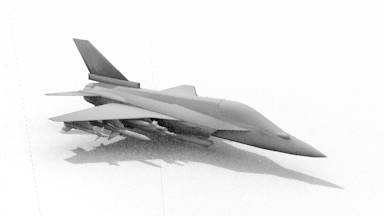

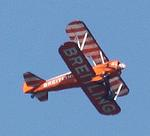

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('/content/drive/MyDrive/DeCoTa/synthetic/aeroplane/src_1_02691156_4f3a64164fbe16f54c2c88971423d0be__129_10_165.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread('/content/drive/MyDrive/DeCoTa/real/aeroplane/aeroplane_160158.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)